# Advanced Research Module Usage

We start with some useful imports and constant definitions

In [1]:
import sys
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline

In [2]:
sys.path.append('../../..')

from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.models.torch import VGG7, VGG16
from batchflow.research import Research, Domain, ResearchResults, E
from batchflow.research.utils import get_metrics

In [3]:
BATCH_SIZE = 64
ITERATIONS = 1000
TEST_EXECUTE_FREQ = 100

## Reducing Extra Dataset Loads

### Running Research Sequentially

In previous tutorial we learned how to use Research to run experimetrs multiple times and with varying parameters.

Firstly we define a dataset to work with and a pipeline that reads this dataset

In [4]:
mnist = MNIST()
train_root = mnist.train.p.run_later(BATCH_SIZE, shuffle=True, n_epochs=None)

Then we define a grid of parameters whose nodes will be used to form separate experiments

In [5]:
domain = Domain(layout=['cna', 'can'], bias=[True, False])        

These parameters can be passed to model's configs using named expressions. 

In [6]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/bias': C('bias'),
}

After that we define a pipeline to run during our experiments. We initialise a pipeline variable `'loss'` to store loss on each iteration

In [7]:
train_template = (Pipeline()
            .init_variable('loss')
            .init_model('conv', VGG7, 'dynamic', config=model_config)
            .to_array(channels='first')
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
)

Finally we define a Research that runs the pipeline substituting its parameters using different nodes of the `grid`, and saves values of the `'loss'` named expressions to results.

In [8]:
research = (Research(domain=domain, n_reps=4)
            .add_pipeline('ppl', train_root + train_template, variables='loss')
)

research.run(n_iters=10, dump_results=False, bar=True)

100%|██████████| 160/160 [03:45<00:00,  1.41s/it]


16 experiments are run (4 grid nodes x 4 repetitions) each consisting of 10 iterations.

We can load results of the research and see that the table has 160 entries.

In [9]:
research.results.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         160 non-null    object 
 1   layout     160 non-null    object 
 2   bias       160 non-null    bool   
 3   iteration  160 non-null    int64  
 4   loss       160 non-null    float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 6.4+ KB


### Branches: Reducing Data Loading and Preprocessing

Each experiment can be divided into 2 stages: root stage that is roughly same for all experiments (for example, data loading and preprocessing) and branch stage that varies. If data loading and preprocessing take significant time one can use the batches generated on a single root stage to feed to several branches that belong to different experiments. 

For example, if you want to test 4 different models, and your workflow includes some complicated data preprocessing and augmentation that is done separatey for each model, you may want to do preprocessing and augmentation once and feed resulting batches of data to all these 4 models. 

![Title](img/Branch_Root_Figure_crop.png)

Figure above shows the difference. 

On the left, simple workflow is shown. Same steps of common preprocessing are performed 4 times, and the batches that are generated after different runs of common stages are also different due to shuffling and possible randomisation inside common steps.

On the right, common steps are performed once on root stage and the very same batches are passed to different branches. This has the advantage of reducing extra computations but it also reduces variability becauce all models get exactly same pieces of data.

To perform root-branch division, one should pass `root` and `branch` parameters to `add_pipeline()` and define number of branches per root via `branches` parameter of `run()`.

A root with corresponding branches is called a **task**. Note that different roots still produce different batches.

One constraint when using branches is that branch pipelines do not calculate dataset variables properly, so we have to redefine `model_config` and `train_template` and hard-code `'inputs/labels/classes'` parameter

In [10]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/bias': C('bias'),
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('conv', VGG7, 'dynamic', config=model_config)
            .to_array(channels='first')
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
)
    
research = (Research(domain=domain, n_reps=4)
            .add_pipeline('ppl', root=train_root, branch=train_template, variables='loss')
           )

research.run(n_iters=10, branches=8, dump_results=False, bar=True)

100%|██████████| 160/160 [00:32<00:00,  4.90it/s]


Scince every root is now assigned to 8 branches, there are only 2 tasks.

We can see that the whole research duration reduced.
In this toy example we use only 10 iterations to make the effect of reduced dataset load more visible.

The numbers of results entries is the same. 

In [11]:
research.results.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         160 non-null    object 
 1   layout     160 non-null    object 
 2   bias       160 non-null    bool   
 3   iteration  160 non-null    int64  
 4   loss       160 non-null    float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 6.4+ KB


### Functions on Root

If each job has several branches, they are all executed in parallel threads. To run a function on root, one should add it with `root=True`.

In [12]:
def function_on_root():
    print('on root')
    
research = (Research(domain=domain, n_reps=4)
            .add_callable(function_on_root, when="#0", root=True)
            .add_pipeline('ppl', train_root, train_template, variables='loss')
           )

# research.run(branches=8, n_iters=10, dump_results=False, bar=True)

## Improving Performance

Research can run experiments in parallel if number of workers if defined in `workers` parameter. 
Each worker starts in a separate process and performs one or several jobs assigned to it. Moreover if several GPU's are accessible one can pass indices of GPUs to use via `devices` parameter.

In [13]:
test_root = mnist.test.p.run_later(BATCH_SIZE, shuffle=True, n_epochs=1) # Note n_epochs=1

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array(channels='first')
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=1, save_to=V('metrics', mode='a')))

research = (Research(domain=domain, n_reps=4)
            .add_pipeline('train_ppl', train_root, train_template, variables='loss')
            .add_pipeline(root=test_root, branch=test_template, name='test_ppl',
                          when=TEST_EXECUTE_FREQ, run=True, import_from=E('train_ppl').pipeline)
            .get_metrics(pipeline=E('test_ppl').pipeline, metrics_var='metrics',
                         metrics_name='accuracy', save_to='accuracy',
                         when=TEST_EXECUTE_FREQ))

research.run(n_iters=ITERATIONS, dump_results=False, bar=True, 
             branches=2, workers=2, devices=[0, 1])

 75%|███████▌  | 12000/16000 [14:54<04:58, 13.42it/s] 


In [14]:
results = research.results.df
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         12000 non-null  object 
 1   layout     12000 non-null  object 
 2   bias       12000 non-null  bool   
 3   iteration  12000 non-null  int64  
 4   loss       12000 non-null  float64
 5   accuracy   120 non-null    float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 574.2+ KB


## Cross-validation

One can easyly perform cross-validation with Research

Firstly we will define a dataset: we will use train subset of MNIST

In [15]:
mnist_train = MNIST().train
mnist_train.cv_split(n_splits=3)

Next, we define our train and test pipelines. To perform cross-validation, you can define train and test datasets as `mnist_train.CV(C('fold')).train` and `mnist_test.CV(C('fold')).test`, correspondingly.

In [16]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('conv', VGG7, 'dynamic', config=model_config)
            .to_array(channels='first')
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None)) << mnist_train.CV(C('fold')).train

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array(channels='first')
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=1, save_to=V('metrics', mode='a'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))  << mnist_train.CV(C('fold')).test

Then add to `Domain` `fold=[0, 1, 2]`.

In [17]:
domain = Domain(layout=['cna', 'can'], fold=[0, 1, 2])

research = (Research(domain=domain)
            .add_pipeline('train_ppl', train_template, variables='train_loss')
            .add_pipeline('test_ppl', test_template, when=TEST_EXECUTE_FREQ,
                          run=True, import_from=E('train_ppl').pipeline)
            .get_metrics(pipeline=E('test_ppl').pipeline, metrics_var='metrics',
                         metrics_name='accuracy', save_to='accuracy',
                         when=TEST_EXECUTE_FREQ))

research.run(n_iters=ITERATIONS, dump_results=False, bar=True, workers=1, devices=[1])

100%|██████████| 6000/6000 [20:01<00:00,  4.99it/s]  


We can now load results, specifying which folds to get if needed

In [18]:
results = research.results.to_df(fold=0, pivot=True)
results.sample(5)

,id,layout,fold,iteration,train_loss,accuracy
1494,44cd312207741836,can,0,494,0.034711,NaN
931,2d4a9cf046772149,cna,0,931,0.022560,NaN
1962,44cd312207741836,can,0,962,0.005521,NaN
1296,44cd312207741836,can,0,296,0.070305,NaN
543,2d4a9cf046772149,cna,0,543,0.185585,NaN


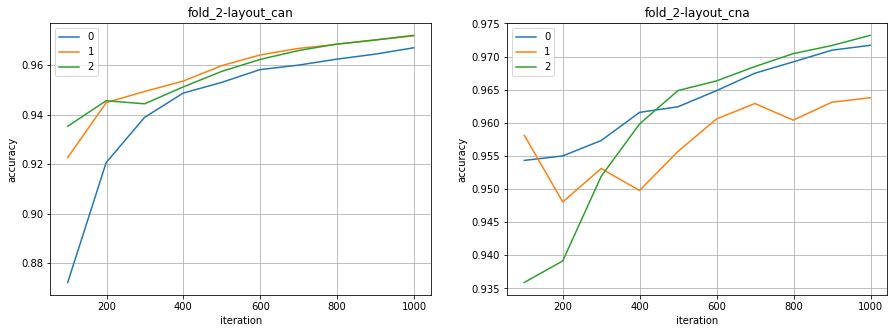

In [19]:
from matplotlib import pyplot as plt
test_results = research.results.to_df(name='accuracy', drop_columns=False, concat_config=True, pivot=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, (config, df) in enumerate(test_results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='fold', values='accuracy').plot(ax=ax[y])
    ax[y].set_title(config)
    ax[y].set_xlabel('iteration')
    ax[y].set_ylabel('accuracy')
    ax[y].grid(True)
    ax[y].legend()